**Addressing Overfitting in the 1st Model**

We can implement the following steps to mitigate overfitting:

1. **Expand the Dataset:** Gather additional data to provide the model with more diverse examples.
2. **Simplify the Model:** Reduce complexity by removing unnecessary nodes or layers from the neural network architecture.
3. **Apply Regularization:** Employ techniques like L1 or L2 regularization to penalize large weights and prevent overfitting.
4. **Feature Selection:** Carefully choose relevant features and eliminate those that might contribute to overfitting.

In this notebook, we will use a simplified model and apply regularization to improve accuracy on the test set.I'll try early stopping, add drop out and training with less epoch to handle overfiting.

# Model 2

## 1. Import library

In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from keras.utils import normalize
from PIL import Image
from sklearn.model_selection import train_test_split

## 2. Loading dataset

In [2]:
no_dir = os.listdir('./data_no/data_no/NO/')
yes_dir = os.listdir('./data_yes/data_yes/YES/')

data_set,label = [],[]
for i,cur_img_dir in enumerate(no_dir):
    #check type of image
    if cur_img_dir.split('.')[1]=='jpg':
        img = cv2.imread('./data_no/data_no/NO/'+cur_img_dir)
        img = Image.fromarray(img,'RGB')
        img = img.resize((64,64))
        data_set.append(np.array(img))
        label.append(0)

for i,cur_img_dir in enumerate(yes_dir):
    #check type of image
    if cur_img_dir.split('.')[1]=='jpg':
        img = cv2.imread('./data_yes/data_yes/YES/'+cur_img_dir)
        img = Image.fromarray(img,'RGB')
        img = img.resize((64,64))
        data_set.append(np.array(img))
        label.append(1)


In [3]:
data_set = np.array(data_set)
label = np.array(label)
data_set.shape

(1092, 64, 64, 3)

## 3. Split and normalize data


In [4]:
import random
seed = 99
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
x_train,x_test,y_train,y_test = train_test_split(
    data_set,label,
    test_size=0.2,
    )
x_train,x_val,y_train,y_val = train_test_split(
    x_train,y_train,
    test_size=0.25,
)
print(f'X train shape: {x_train.shape}\nY train shape: {y_train.shape}\nX test shape: {x_test.shape}\nY test shape: {y_test.shape}\nX validation shape: {x_val.shape}\nY validation shape: {x_val.shape}')

X train shape: (654, 64, 64, 3)
Y train shape: (654,)
X test shape: (219, 64, 64, 3)
Y test shape: (219,)
X validation shape: (219, 64, 64, 3)
Y validation shape: (219, 64, 64, 3)


### Adding scaler method of nb4


In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib 
# using scaler of nb4
scaler = joblib.load('scaler.pkl') 
# Reshape data to fit with MinMaxScaler
x_train_reshaped = x_train.reshape(-1, x_train.shape[-1])
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])
x_val_reshaped = x_val.reshape(-1, x_val.shape[-1])

x_train_reshaped = scaler.fit_transform(x_train_reshaped)
x_test_reshaped = scaler.transform(x_test_reshaped)
x_val_reshaped = scaler.transform(x_val_reshaped)
# Print mean and std after scaling
print("\nAfter scaling:")
print(f"Train mean: {x_train_reshaped.mean(axis=0)}")
print(f"Train std: {x_train_reshaped.std(axis=0)}")
print(f"Test mean: {x_test_reshaped.mean(axis=0)}")
print(f"Test std: {x_test_reshaped.std(axis=0)}")
print(f"Validation mean: {x_val_reshaped.mean(axis=0)}")
print(f"Validation std: {x_val_reshaped.std(axis=0)}")


# Reshape to original shape
x_train = x_train_reshaped.reshape(x_train.shape)
x_test = x_test_reshaped.reshape(x_test.shape)
x_val = x_val_reshaped.reshape(x_val.shape)


After scaling:
Train mean: [4.73241486e-14 4.73241486e-14 4.73241486e-14]
Train std: [1. 1. 1.]
Test mean: [0.03089532 0.03089532 0.03089532]
Test std: [1.01023685 1.01023685 1.01023685]
Validation mean: [0.02535402 0.02535402 0.02535402]
Validation std: [1.00168052 1.00168052 1.00168052]


## 4. Building model

In [7]:
from keras.models import Sequential 
from tensorflow.keras.regularizers import l2
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Activation,
    Dropout,
    Flatten,
    Dense
)

In [14]:
INPUT_SIZE = 64
weight_decay = 1e-4

model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), input_shape=(INPUT_SIZE, INPUT_SIZE, 3), kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 5. Training model

In [15]:
from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(
    # adding amsgrad method to ensure output when running 
    # trainin model again
    optimizer=Adam(amsgrad=True), 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,225 (688.38 KB)

 Trainable params: 176,225 (688.38 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    restore_best_weights=True
    )

# Train the model with early stopping
history = model.fit(
    x_train,
    y_train,
    batch_size=16,
    verbose=1,
    epochs=20,
    validation_data=(x_val, y_val),
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5528 - loss: 0.8468 - val_accuracy: 0.8219 - val_loss: 0.4245
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8478 - loss: 0.3898 - val_accuracy: 0.9224 - val_loss: 0.2570
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8930 - loss: 0.2667 - val_accuracy: 0.9269 - val_loss: 0.2088
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9337 - loss: 0.1957 - val_accuracy: 0.9498 - val_loss: 0.1988
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9416 - loss: 0.1849 - val_accuracy: 0.9498 - val_loss: 0.1604
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9667 - loss: 0.1356 - val_accuracy: 0.9498 - val_loss: 0.1542
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9647 - loss: 0.1152 - val_accuracy: 0.9406 - val_loss: 0.1588
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9823 - loss: 0.0901 - val_accuracy: 0.9543 - v

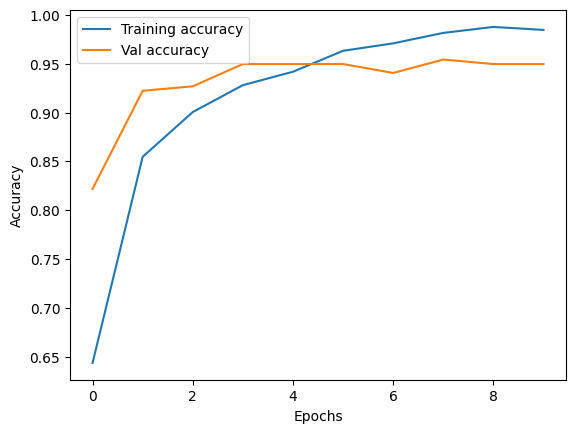

In [31]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy,label = 'Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

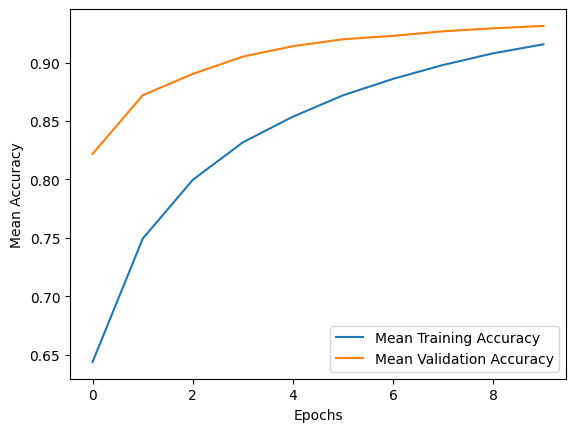

In [32]:
# Calculate cumulative mean accuracy
mean_accuracy = np.cumsum(accuracy) / np.arange(1, len(accuracy) + 1)
mean_val_accuracy = np.cumsum(val_accuracy) / np.arange(1, len(val_accuracy) + 1)

# Plot cumulative mean accuracy and validation accuracy
plt.plot(mean_accuracy, label='Mean Training Accuracy')
plt.plot(mean_val_accuracy, label='Mean Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.show()

## 6. Test with new data

In [24]:
y_test_pred = model.predict(x_test)
y_pred = (y_test_pred >0.5).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [25]:
y_test_reshape = y_test.reshape(-1,1)
print("Accuracy in test set:", accuracy_score(y_test_reshape, y_pred))
print('Accuracy in validation set:',history.history['val_accuracy'][-1])

Accuracy in test set: 0.954337899543379
Accuracy in validation set: 0.9497717022895813


**This model gain 94.5% accuracy in test set. Now it's good to use!**

## Save model

**Infor**<br>
Name: BrainTurmor_v2<br>
Accuracy in train set: 0.97<br>
Accuracy in validation set: 0.94<br>
Accuracy in test set: 0.95<br>

Status: Good

In [26]:
model.save('BrainTurmor_v2.keras')